In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from scipy.fftpack import dctn, idctn
from tqdm import tqdm
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from src import *

In [2]:
patch_xy = 512
frames_per_patch = 512
window = 128

In [ ]:
vpm_x_path = DATASETS["oabf_vpm"].dir / "x.tiff"
vpm_y_path = DATASETS["oabf_vpm"].dir / "y.tiff"
vpm_x, vpm_y = (Recording(_, max_frames=frames_per_patch * 2) for _ in [vpm_x_path, vpm_y_path])

In [4]:
patch = vpm_x.np[frames_per_patch : frames_per_patch * 2, :patch_xy, :patch_xy]
patch_deepcad = vpm_y.np[frames_per_patch : frames_per_patch * 2, :patch_xy, :patch_xy]
patch_mean = np.empty_like(patch)
for i in tqdm(range(patch.shape[0])):
    patch_mean[i] = vpm_x.avg(frames_per_patch + i, window=window)[:patch_xy, :patch_xy]

100%|██████████| 512/512 [00:12<00:00, 40.06it/s]


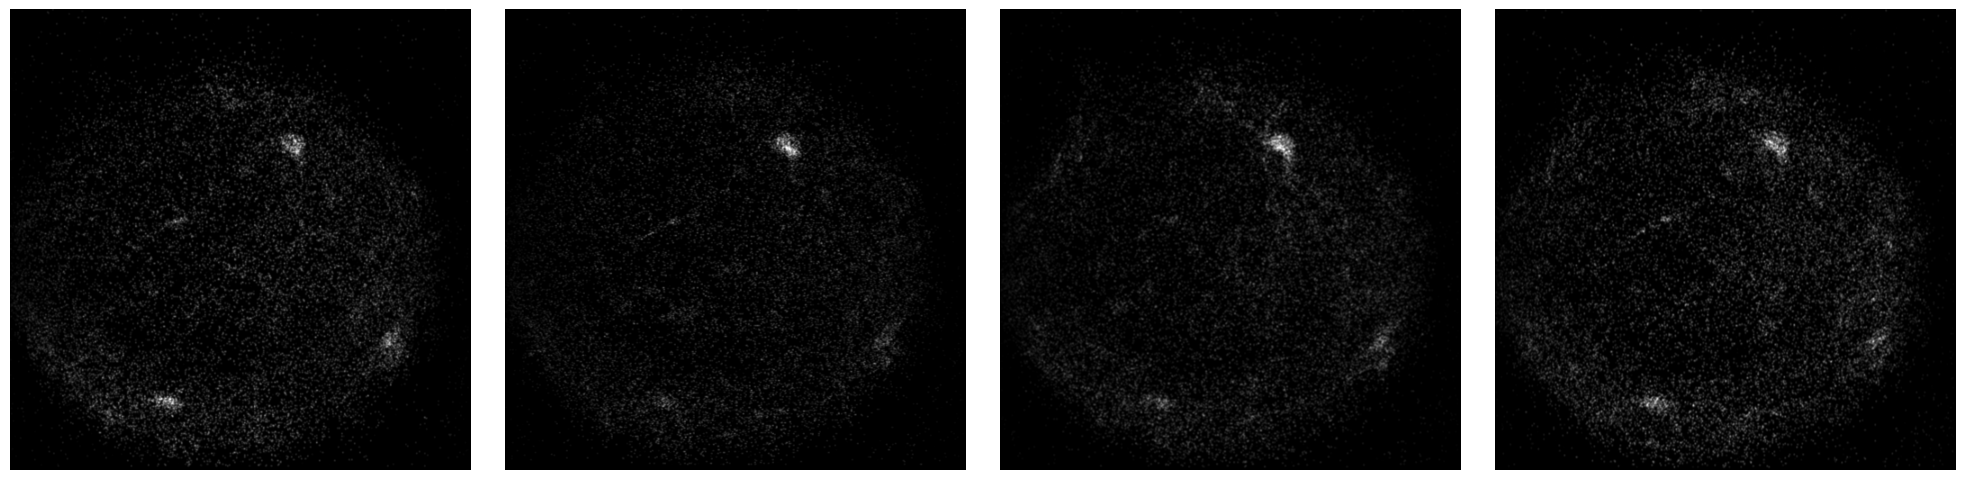

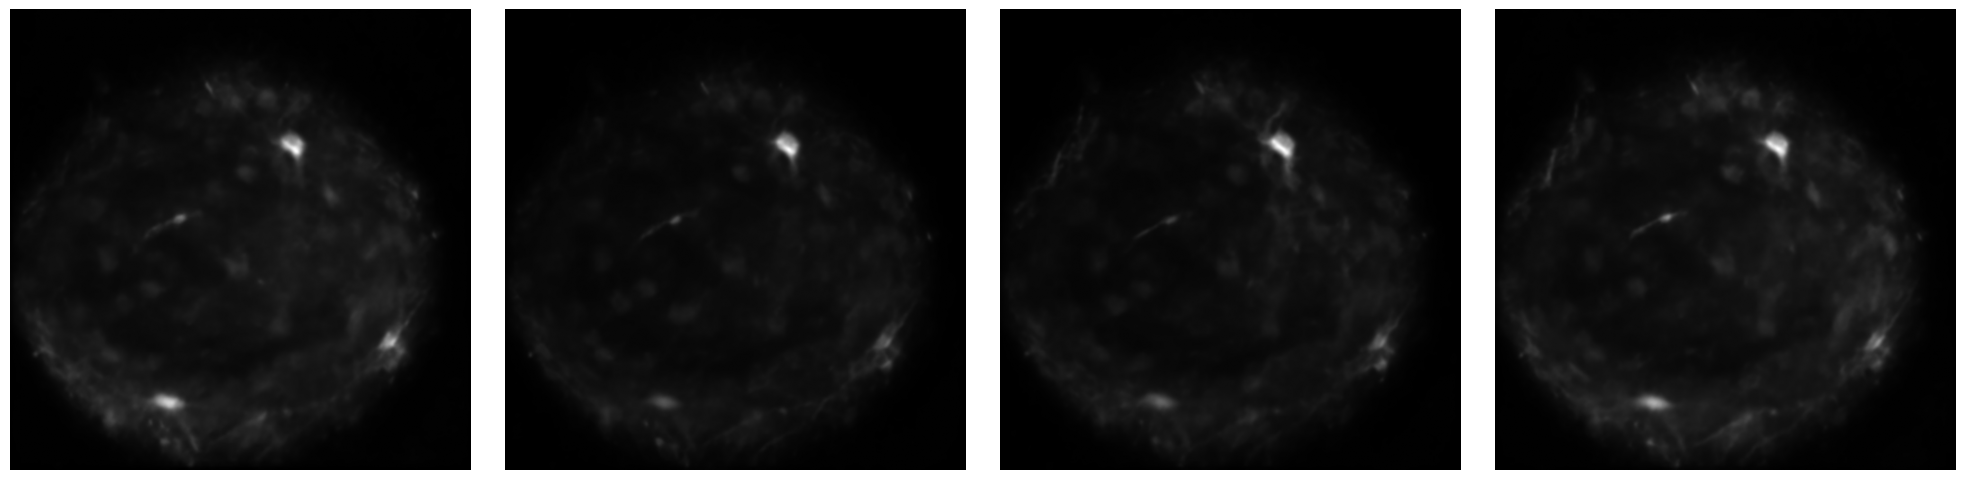

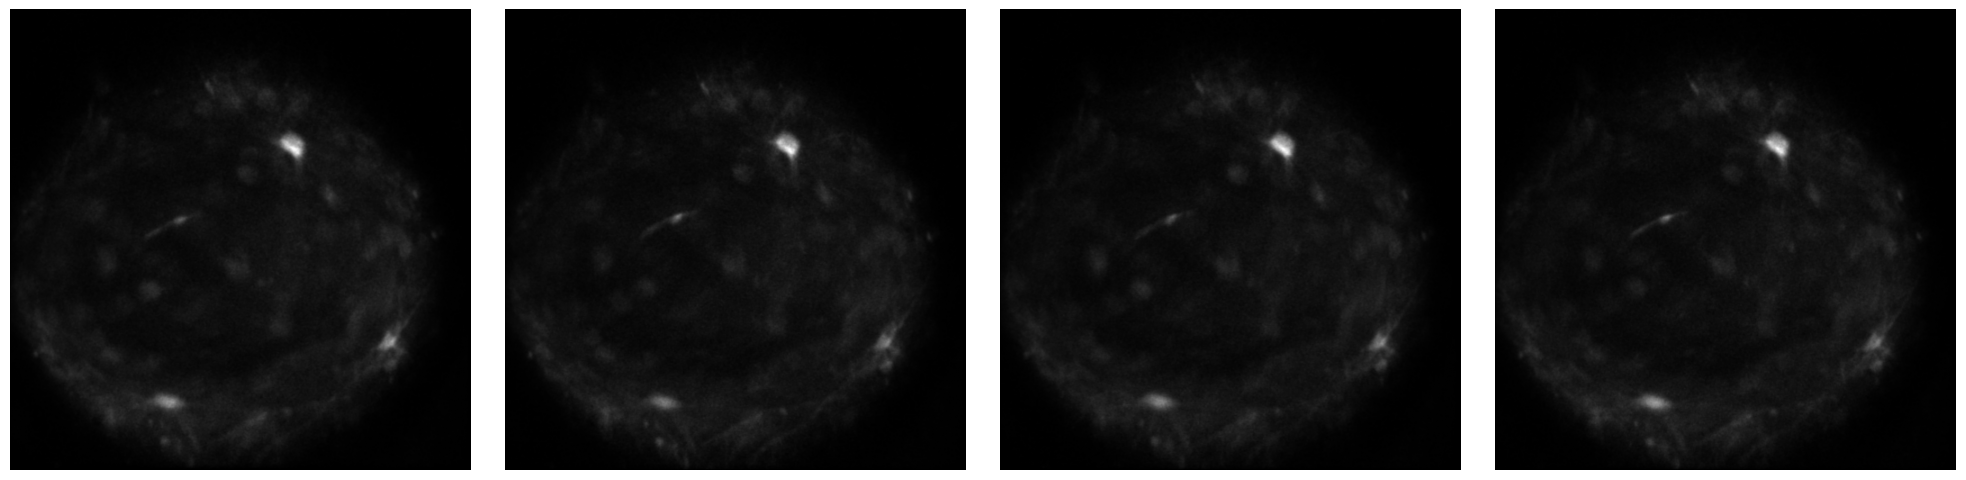

In [5]:
max_frames=4
imshow([_ for _ in patch[::128]], cmap="grey",size=5, cols=max_frames)
imshow([_ for _ in patch_deepcad[::128]], cmap="grey",size=5, cols=max_frames)
imshow([_ for _ in patch_mean[::128]], cmap="grey",size=5, cols=max_frames)

In [6]:
def merge_dct_smooth(dct_hf_xy, dct_hf_z, s0, δ_s, t0, δ_t):
    T, H, W = dct_hf_xy.shape
    t = np.arange(T)[:, None, None]
    y = np.arange(H)[None, :, None]
    x = np.arange(W)[None, None, :]

    # normalized ramps in [0,1]
    r = np.sqrt(y**2 + x**2)
    w_s = np.clip((r - (s0 - δ_s)) / (2 * δ_s), 0, 1)  # grows from 0→1 around s0
    w_t = np.clip((t - (t0 - δ_t)) / (2 * δ_t), 0, 1)  # grows from 0→1 around t0

    # combined weight for dct1: high spatial but suppressed by temporal
    W1 = w_s * (1 - w_t)
    merged = W1 * dct_hf_xy + (1 - W1) * dct_hf_z

    return W1, merged, idctn(merged, norm="ortho")

In [7]:
patch_deepcad_dct = dctn(patch_deepcad, type=2, norm="ortho")
patch_mean_dct = dctn(patch_mean, type=2, norm="ortho")

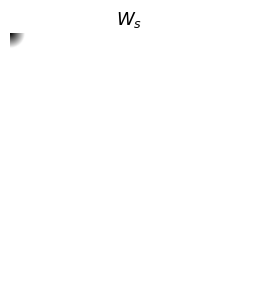

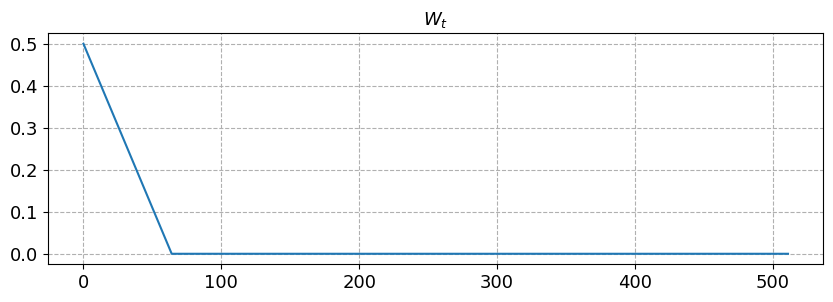

In [8]:
s0 = 8 
δ_s = 24 
t0 = 0
δ_t = 64

W_s = np.clip(
    (np.sqrt(np.arange(patch_xy)[None, :] ** 2 + np.arange(patch_xy)[:, None] ** 2) - (s0 - δ_s)) / (2 * δ_s), 0, 1
)
W_t = 1 - np.clip((np.arange(frames_per_patch) - (t0 - δ_t)) / (2 * δ_t), 0, 1)
imshow({"$W_s$": W_s}, size=3)
pd.Series(W_t).plot(figsize=(10, 3), title="$W_t$");

DeepCAD frames


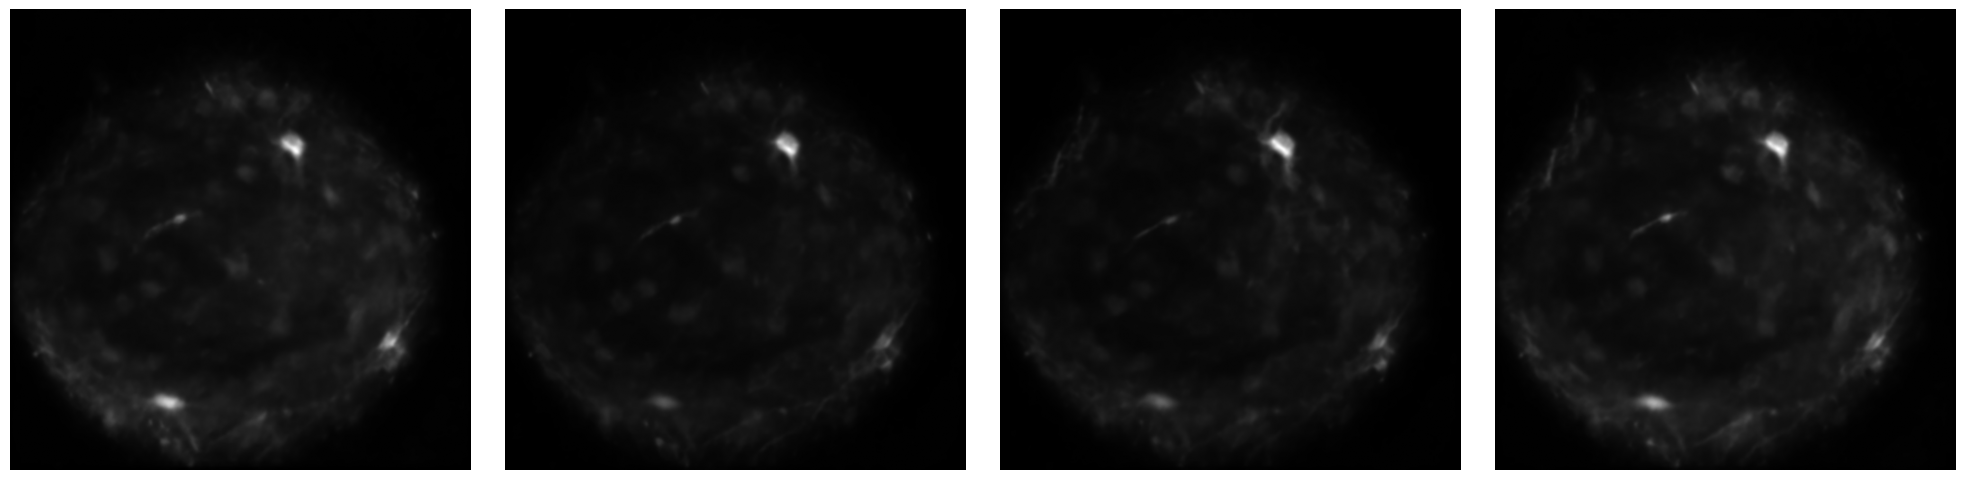

Fused frames


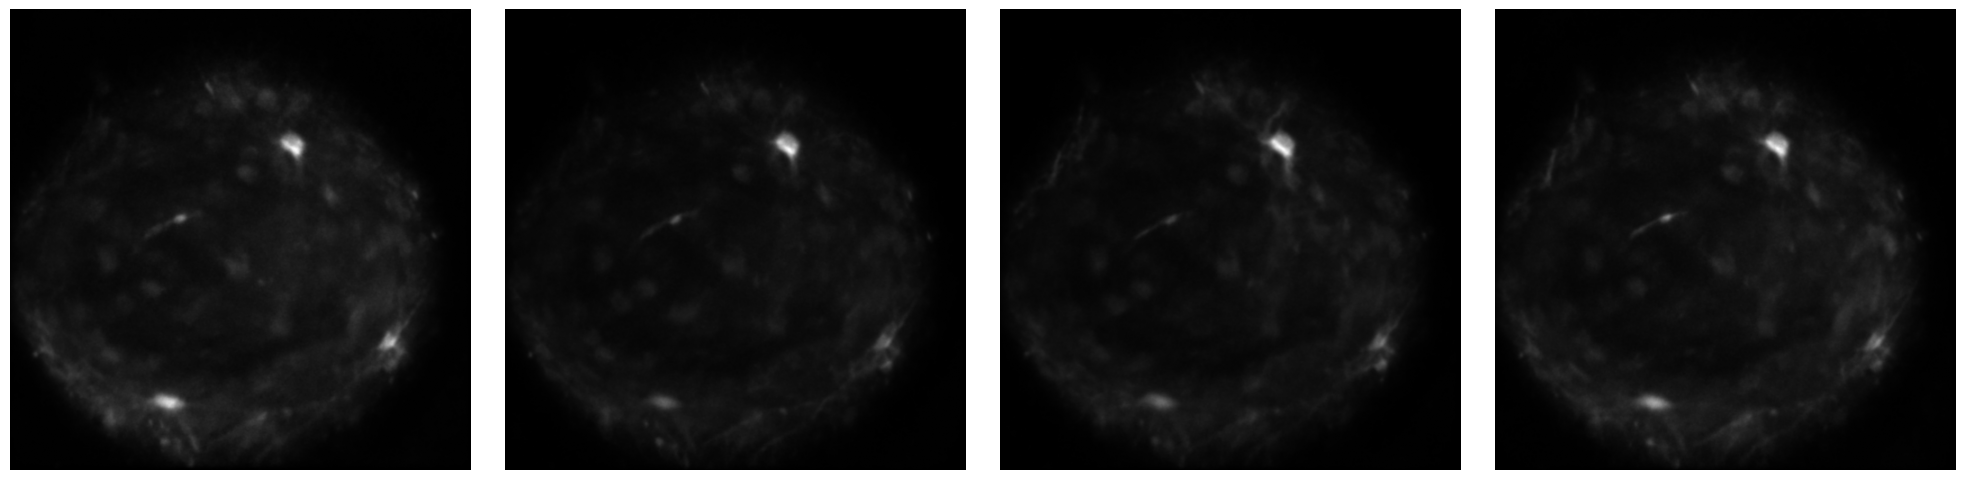

Averaged frames


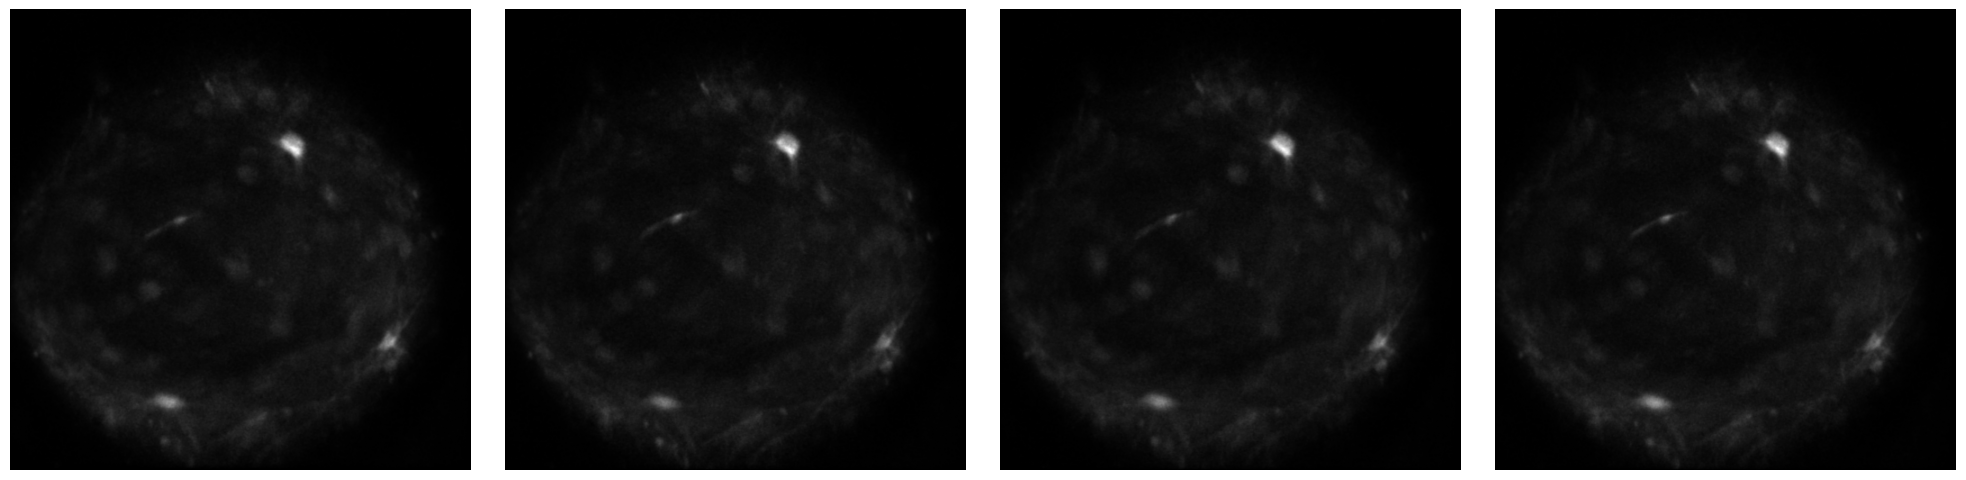

In [9]:
W, fused_dct, fused = merge_dct_smooth(patch_mean_dct, patch_deepcad_dct, s0, δ_s, t0, δ_t)
# cprint("green:Weight mask in DCT space")
# imshow([_ for _ in W[::64]], cmap="grey", size=2, cols=8, vrange=(0, 1))
# imshow([_ for _ in fused_dct[::16]], cmap="grey", size=5, cols=max_frames)
cprint("blue:DeepCAD frames")
imshow([_ for _ in patch_deepcad[::128]], cmap="grey", size=5, cols=max_frames)
cprint("yellow:Fused frames")
imshow([_ for _ in fused[::128]], cmap="grey", size=5, cols=max_frames)
cprint("red:Averaged frames")
imshow([_ for _ in patch_mean[::128]], cmap="grey", size=5, cols=max_frames)

In [10]:
cprint("blue:DeepCAD frames")
display(Recording(patch_deepcad).render(f"vpm_deepcad.mp4"))
cprint("yellow:Fused frames")
display(Recording(fused).render(f"vpm_dct_fused_{s0}_{δ_s}_{t0}_{δ_t}.mp4"))
cprint("red:Averaged frames")
display(Recording(patch_mean).render(f"vpm_avg.mp4"))

DeepCAD frames


Fused frames


Averaged frames
